先来回顾一下交易策略模块（Strategy）的构成。交易策略类代码包含参数或函数名如下：
（1）params-全局参数，可选：更改交易策略中变量/参数的值，可用于参数调优。

（2）log：日志，可选：记录策略的执行日志，可以打印出该函数提供的日期时间和txt变量。

（3） init：用于初始化交易策略的类实例的代码。

（4）notify_order，可选：跟踪交易指令（order）的状态。order具有提交，接受，买入/卖出执行和价格，已取消/拒绝等状态。

（5）notify_trade，可选：跟踪交易的状态，任何已平仓的交易都将报告毛利和净利润。

（6）next，必选：制定交易策略的函数，策略模块最核心的部分。

In [3]:
import pandas as pd  
from datetime import datetime
import backtrader as bt
import numpy as np
import tushare as ts
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [4]:
class MyStrategy(bt.Strategy):
    params=(('maperiod',15),
            ('printlog',False),)

    def __init__(self):
        #指定价格序列
        self.dataclose=self.datas[0].close

        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None

        #添加移动均线指标
        self.sma = bt.indicators.SimpleMovingAverage(
                      self.datas[0], period=self.params.maperiod)

    #策略核心，根据条件执行买卖交易指令（必选）
    def next(self):
        # 记录收盘价
        #self.log(f'收盘价, {dataclose[0]}')
        if self.order: # 检查是否有指令等待执行, 
            return
        # 检查是否持仓   
        if not self.position: # 没有持仓
            #执行买入条件判断：收盘价格上涨突破15日均线
            if self.dataclose[0] > self.sma[0]:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                #执行买入
                self.order = self.buy()         
        else:
            #执行卖出条件判断：收盘价格跌破15日均线
            if self.dataclose[0] < self.sma[0]:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                #执行卖出
                self.order = self.sell()

    #交易记录日志（可省略，默认不输出结果）
    def log(self, txt, dt=None,doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')

    #记录交易执行情况（可省略，默认不输出结果）
    def notify_order(self, order):
        # 如果order为submitted/accepted,返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果order为buy/sell executed,报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入:\n价格:{order.executed.price},\
                成本:{order.executed.value},\
                手续费:{order.executed.comm}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出:\n价格：{order.executed.price},\
                成本: {order.executed.value},\
                手续费{order.executed.comm}')
            self.bar_executed = len(self) 

        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None

    #记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益：\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')

    #回测结束后输出结果（可省略，默认输出结果）
    def stop(self):
        self.log('(MA均线： %2d日) 期末总资金 %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)

In [5]:
def main(code,start,end='',startcash=10000,qts=500,com=0.001):
    #创建主控制器
    cerebro = bt.Cerebro()      
    #导入策略参数寻优
    cerebro.optstrategy(MyStrategy,maperiod=range(3, 31))    
    #获取数据
    df=ts.get_k_data(code,autype='qfq',start=start,end=end)
    df.index=pd.to_datetime(df.date)
    df=df[['open','high','low','close','volume']]
    #将数据加载至回测系统
    data = bt.feeds.PandasData(dataname=df)    
    cerebro.adddata(data)
    #broker设置资金、手续费
    cerebro.broker.setcash(startcash)           
    cerebro.broker.setcommission(commission=com)    
    #设置买入设置，策略，数量
    cerebro.addsizer(bt.sizers.FixedSize, stake=qts)   
    print('期初总资金: %.2f' %                    
    cerebro.broker.getvalue())    
    cerebro.run(maxcpus=1)    
    print('期末总资金: %.2f' % cerebro.broker.getvalue())

下面定义一个主函数，用于对某股票指数（个股）在指定期间进行回测，使用tushare的旧接口获取数据，包含开盘价、最高价、最低价、收盘价和成交量。这里主要以3到30日均线为例进行参数寻优，考察以多少日均线与价格的交叉作为买卖信号能获得最大的收益。

In [6]:
def main(code,start,end='',startcash=10000,qts=500,com=0.001):
    #创建主控制器
    cerebro = bt.Cerebro()      
    #导入策略参数寻优
    cerebro.optstrategy(MyStrategy,maperiod=range(3, 31))    
    #获取数据
    df=ts.get_k_data(code,autype='qfq',start=start,end=end)
    df.index=pd.to_datetime(df.date)
    df=df[['open','high','low','close','volume']]
    #将数据加载至回测系统
    data = bt.feeds.PandasData(dataname=df)    
    cerebro.adddata(data)
    #broker设置资金、手续费
    cerebro.broker.setcash(startcash)           
    cerebro.broker.setcommission(commission=com)    
    #设置买入设置，策略，数量
    cerebro.addsizer(bt.sizers.FixedSize, stake=qts)   
    print('期初总资金: %.2f' %                    
    cerebro.broker.getvalue())    
    cerebro.run(maxcpus=1)    
    print('期末总资金: %.2f' % cerebro.broker.getvalue())

再定义一个画图函数，对相应股票（指数）在某期间的价格走势和累计收益进行可视化。

In [7]:
def plot_stock(code,title,start,end):
    dd=ts.get_k_data(code,autype='qfq',start=start,end=end)
    dd.index=pd.to_datetime(dd.date)
    dd.close.plot(figsize=(14,6),color='r')
    plt.title(title+'价格走势\n'+start+':'+end,size=15)
    plt.annotate(f'期间累计涨幅:{(dd.close[-1]/dd.close[0]-1)*100:.2f}%', xy=(dd.index[-150],dd.close.mean()), 
             xytext=(dd.index[-500],dd.close.min()), bbox = dict(boxstyle = 'round,pad=0.5',
            fc = 'yellow', alpha = 0.5),
             arrowprops=dict(facecolor='green', shrink=0.05),fontsize=12)
    plt.show()

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


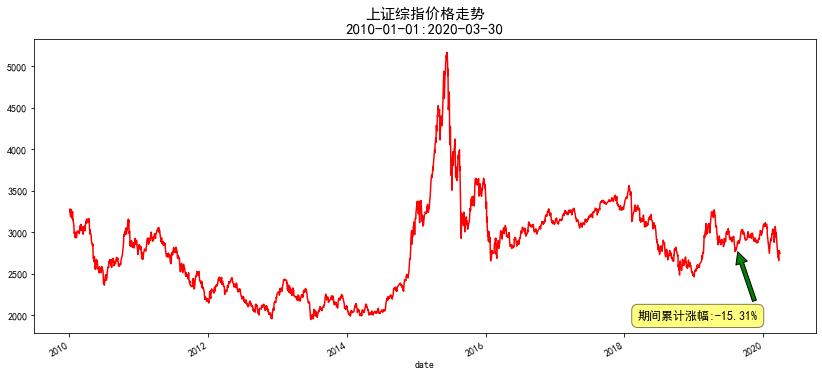

In [8]:
plot_stock('sh','上证综指','2010-01-01','2020-03-30')

下面分别对3-30日均线进行回测，这里假设指数可以交易，初始资金为100万元，每次交易100股，注意如果指数收盘价乘以100超过可用资金，会出现交易失败的情况，换句话说在整个交易过程中，是交易固定数量的标的，因此仓位的大小跟股价有直接关系。

In [9]:
main('sh','2010-01-01','',1000000,100)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
期初总资金: 1000000.00
2020-10-26,(MA均线：  3日) 期末总资金 637487.79
2020-10-26,(MA均线：  4日) 期末总资金 729546.63
2020-10-26,(MA均线：  5日) 期末总资金 835875.19
2020-10-26,(MA均线：  6日) 期末总资金 791516.20
2020-10-26,(MA均线：  7日) 期末总资金 825865.55
2020-10-26,(MA均线：  8日) 期末总资金 882152.59
2020-10-26,(MA均线：  9日) 期末总资金 900888.58
2020-10-26,(MA均线： 10日) 期末总资金 876504.66
2020-10-26,(MA均线： 11日) 期末总资金 921889.16
2020-10-26,(MA均线： 12日) 期末总资金 929941.81
2020-10-26,(MA均线： 13日) 期末总资金 1014028.33
2020-10-26,(MA均线： 14日) 期末总资金 1056570.41
2020-10-26,(MA均线： 15日) 期末总资金 1050959.51
2020-10-26,(MA均线： 16日) 期末总资金 1070779.71
2020-10-26,(MA均线： 17日) 期末总资金 1039325.53
2020-10-26,(MA均线： 18日) 期末总资金 1055291.14
2020-10-26,(MA均线： 19日) 期末总资金 1094337.60
2020-10-26,(MA均线： 20日) 期末总资金 1088991.88
2020-10-26,(MA均线： 21日) 期末总资金 1101153.18
2020-10-26,(MA均线： 22日) 期末总资金 1040048.60
2020-10-26,(MA均线： 23日) 期末总资金 1047758.04
2020-10-26,(MA均线： 24日) 期末总资金 1014543.03
2020-10-26,(MA均线： 25日) 期末总资金 945004.11
2020-10-26,(MA均线： 26

下面分期间进一步回测，考察同一标的，不同区间参数是否有显著差异。将上证综指分为两个期间，2010-2015（期间收益率59.27%），205-2020（期间收益率-44%）。

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


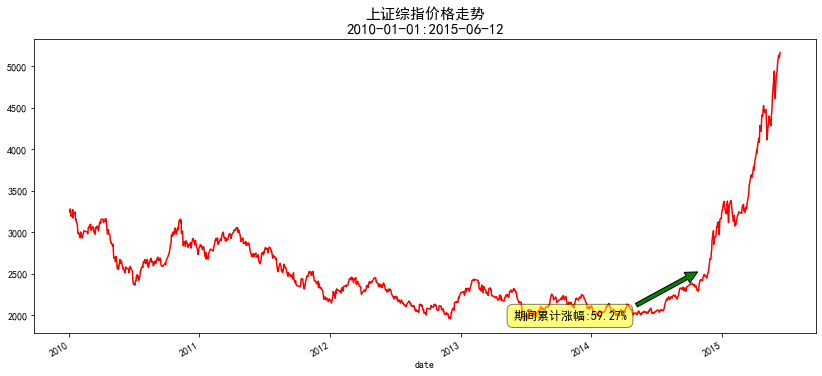

In [10]:
plot_stock('sh','上证综指','2010-01-01','2015-06-12')

In [11]:
main('sh','2010-01-01','2015-06-12',1000000,100)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
期初总资金: 1000000.00
2015-06-12,(MA均线：  3日) 期末总资金 947352.84
2015-06-12,(MA均线：  4日) 期末总资金 1004574.58
2015-06-12,(MA均线：  5日) 期末总资金 1043096.93
2015-06-12,(MA均线：  6日) 期末总资金 1047785.44
2015-06-12,(MA均线：  7日) 期末总资金 1067473.31
2015-06-12,(MA均线：  8日) 期末总资金 1097479.93
2015-06-12,(MA均线：  9日) 期末总资金 1080744.83
2015-06-12,(MA均线： 10日) 期末总资金 1073816.03
2015-06-12,(MA均线： 11日) 期末总资金 1123986.16
2015-06-12,(MA均线： 12日) 期末总资金 1129896.18
2015-06-12,(MA均线： 13日) 期末总资金 1170125.75
2015-06-12,(MA均线： 14日) 期末总资金 1205867.19
2015-06-12,(MA均线： 15日) 期末总资金 1199949.03
2015-06-12,(MA均线： 16日) 期末总资金 1200552.43
2015-06-12,(MA均线： 17日) 期末总资金 1189325.36
2015-06-12,(MA均线： 18日) 期末总资金 1219101.63
2015-06-12,(MA均线： 19日) 期末总资金 1247317.24
2015-06-12,(MA均线： 20日) 期末总资金 1245069.04
2015-06-12,(MA均线： 21日) 期末总资金 1258642.09
2015-06-12,(MA均线： 22日) 期末总资金 1249307.54
2015-06-12,(MA均线： 23日) 期末总资金 1242252.71
2015-06-12,(MA均线： 24日) 期末总资金 1216045.47
2015-06-12,(MA均线： 25日) 期末总资金 1187010.10
2015-06-12

**结果显示是21日均线最优。**

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


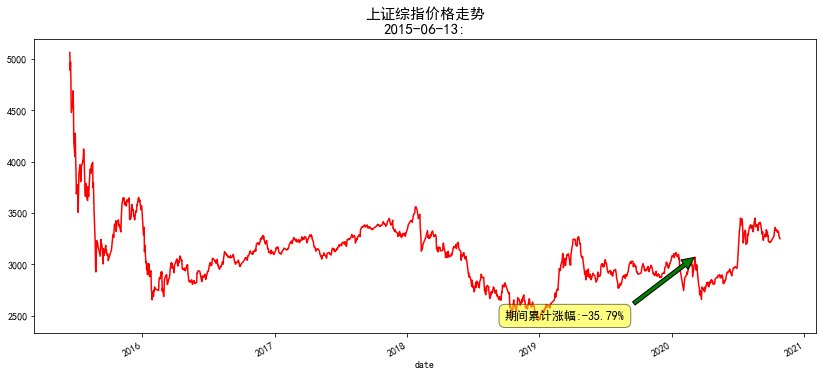

In [12]:
plot_stock('sh','上证综指','2015-06-13','')

In [13]:
main('sh','2015-06-13','',1000000,100)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
期初总资金: 1000000.00
2020-10-26,(MA均线：  3日) 期末总资金 706829.39
2020-10-26,(MA均线：  4日) 期末总资金 741666.49
2020-10-26,(MA均线：  5日) 期末总资金 809472.70
2020-10-26,(MA均线：  6日) 期末总资金 760425.21
2020-10-26,(MA均线：  7日) 期末总资金 775086.68
2020-10-26,(MA均线：  8日) 期末总资金 801367.11
2020-10-26,(MA均线：  9日) 期末总资金 836838.19
2020-10-26,(MA均线： 10日) 期末总资金 830757.68
2020-10-26,(MA均线： 11日) 期末总资金 825972.05
2020-10-26,(MA均线： 12日) 期末总资金 828114.69
2020-10-26,(MA均线： 13日) 期末总资金 871971.63
2020-10-26,(MA均线： 14日) 期末总资金 878772.28
2020-10-26,(MA均线： 15日) 期末总资金 905301.78
2020-10-26,(MA均线： 16日) 期末总资金 924518.57
2020-10-26,(MA均线： 17日) 期末总资金 904291.47
2020-10-26,(MA均线： 18日) 期末总资金 890480.81
2020-10-26,(MA均线： 19日) 期末总资金 901311.65
2020-10-26,(MA均线： 20日) 期末总资金 892033.83
2020-10-26,(MA均线： 21日) 期末总资金 890622.08
2020-10-26,(MA均线： 22日) 期末总资金 838852.06
2020-10-26,(MA均线： 23日) 期末总资金 853616.32
2020-10-26,(MA均线： 24日) 期末总资金 846608.55
2020-10-26,(MA均线： 25日) 期末总资金 806105.00
2020-10-26,(MA均线： 26日) 期末总资金 847

这一期间指数收益率是-44%，采用均线策略进行交易最后获得的收益也是负的，最好的结果是采用16日均线，亏损相对小些。



再看一下个股情况，以浦发银行为例：

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


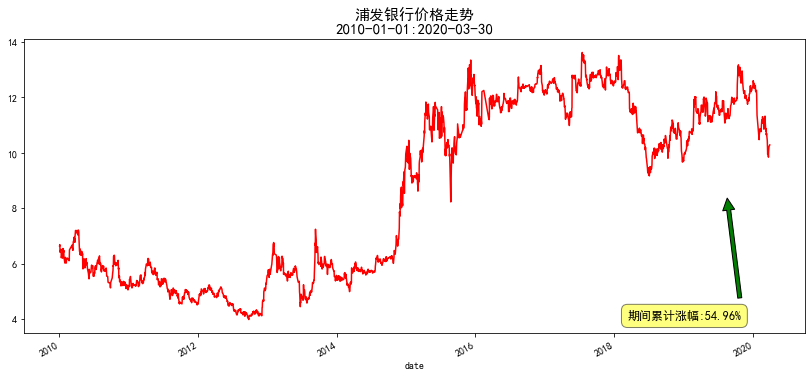

In [14]:
#浦发银行股票
plot_stock('600000','浦发银行','2010-01-01','2020-03-30')

注意，这里初始资金设置为10000，每次交易1000股，这个可以根据自己需要进行设定。从下面结果可以看出整个回测期间收益率没有很高，这个与仓位设定有关，每次交易数量如果设定太大可能导致交易失败，如果设置太小，导致资金没有充分利用，总的收益会比较小。

In [15]:
main('600000','2010-01-01','',10000,1000)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
期初总资金: 10000.00
2020-10-26,(MA均线：  3日) 期末总资金 10271.38
2020-10-26,(MA均线：  4日) 期末总资金 11689.16
2020-10-26,(MA均线：  5日) 期末总资金 10315.54
2020-10-26,(MA均线：  6日) 期末总资金 8984.69
2020-10-26,(MA均线：  7日) 期末总资金 10328.78
2020-10-26,(MA均线：  8日) 期末总资金 10138.51
2020-10-26,(MA均线：  9日) 期末总资金 9252.55
2020-10-26,(MA均线： 10日) 期末总资金 11909.19
2020-10-26,(MA均线： 11日) 期末总资金 11585.51
2020-10-26,(MA均线： 12日) 期末总资金 13133.24
2020-10-26,(MA均线： 13日) 期末总资金 12948.96
2020-10-26,(MA均线： 14日) 期末总资金 13212.03
2020-10-26,(MA均线： 15日) 期末总资金 12576.21
2020-10-26,(MA均线： 16日) 期末总资金 12642.15
2020-10-26,(MA均线： 17日) 期末总资金 12164.43
2020-10-26,(MA均线： 18日) 期末总资金 12544.37
2020-10-26,(MA均线： 19日) 期末总资金 11879.71
2020-10-26,(MA均线： 20日) 期末总资金 11674.36
2020-10-26,(MA均线： 21日) 期末总资金 11812.04
2020-10-26,(MA均线： 22日) 期末总资金 11625.23
2020-10-26,(MA均线： 23日) 期末总资金 12239.61
2020-10-26,(MA均线： 24日) 期末总资金 11791.49
2020-10-26,(MA均线： 25日) 期末总资金 13100.87
2020-10-26,(MA均线： 26日) 期末总资金 12415.42
2020-10-26,(MA均线： 27日

从结果可以看出，浦发银行的最优参数是14日均线，看来使用均线进行交易，最优参数的选择可能因标的期间选择的不同而存在差异。



下面以继续以浦发银行股票为例，输出整个回测过程中的交易日志，即报告买入卖出价格、成本、手续费、策略收益等。

In [16]:
# 初始化cerebro回测系统设置                           
cerebro = bt.Cerebro()
#获取数据
df=ts.get_k_data('600000',autype='qfq',start='2010-01-01',end='2020-03-30')
df.index=pd.to_datetime(df.date)
df=df[['open','high','low','close','volume']]
data = bt.feeds.PandasData(dataname=df,                               
                            fromdate=datetime(2010, 1, 1),                               
                            todate=datetime(2020, 3, 30) )
# 加载数据
cerebro.adddata(data) 
# 将交易策略加载到回测系统中
#设置printlog=True，表示打印交易日志log
cerebro.addstrategy(MyStrategy,maperiod=14,printlog=True) 
# 设置初始资本为10,000
cerebro.broker.setcash(10000.0) 
# 设置交易手续费为 0.1%
cerebro.broker.setcommission(commission=0.001) 
#设置买入设置，策略，数量
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)  

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [17]:
#回测结果
cerebro.run()
#获取最后总资金
portvalue = cerebro.broker.getvalue()
#Print out the final result
print(f'总资金: {portvalue:.2f}')

2010-01-22,BUY CREATE, 6.54
2010-01-25,买入:
价格:6.437,                成本:6437.0,                手续费:6.437
2010-01-27,SELL CREATE, 6.22
2010-01-28,卖出:
价格：6.193,                成本: 6437.0,                手续费6.193
2010-01-28,策略收益：
毛收益 -244.00, 净收益 -256.63
2010-02-12,BUY CREATE, 6.20
2010-02-22,买入:
价格:6.177,                成本:6177.0,                手续费:6.177
2010-02-23,SELL CREATE, 6.10
2010-02-24,卖出:
价格：6.058,                成本: 6177.0,                手续费6.058
2010-02-24,策略收益：
毛收益 -119.00, 净收益 -131.23
2010-02-24,BUY CREATE, 6.16
2010-02-25,买入:
价格:6.183,                成本:6183.0,                手续费:6.183
2010-04-12,SELL CREATE, 7.02
2010-04-13,卖出:
价格：7.013,                成本: 6183.0,                手续费7.013
2010-04-13,策略收益：
毛收益 830.00, 净收益 816.80
2010-04-13,BUY CREATE, 7.21
2010-04-14,买入:
价格:7.239,                成本:7239.0,                手续费:7.239
2010-04-16,SELL CREATE, 6.91
2010-04-19,卖出:
价格：6.791,                成本: 7239.0,                手续费6.791
2010-04-19,策略收益：
毛收益 -448.00, 净收益 -462.0

<IPython.core.display.Javascript object>


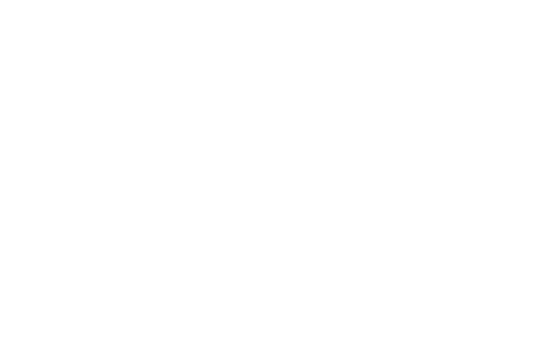

[[<Figure size 432x288 with 4 Axes>]]

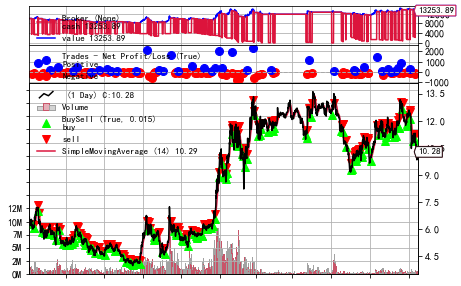

In [18]:
%matplotlib inline 
cerebro.plot()